In [1]:
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
import gender_guesser.detector as gg
import country_converter as coco
# go one up
os.chdir("..")
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

In [2]:
main_color = "#5b3d91"
remerged_data = pd.read_csv(f'data{os.sep}prepared{os.sep}remerged_data.csv')
# Remove the unrelated clusters
other_topic_clusters_shallow = [6, 7, 8, 14, 15, 16, 18, 19, 22, 23]
shape_before = remerged_data.shape
remerged_data = remerged_data[~remerged_data["Cluster"].isin(other_topic_clusters_shallow)]
shape_after = remerged_data.shape
print(f"Removed clusters (shallow): {shape_before[0] - shape_after[0]}")
print(f"New shape: {shape_after}")
other_topic_clusters_deep = [13, 20, 21]
shape_before = remerged_data.shape
remerged_data = remerged_data[~remerged_data["Cluster"].isin(other_topic_clusters_deep)]
shape_after = remerged_data.shape
print(f"Removed clusters (deep): {shape_before[0] - shape_after[0]}")
print(f"New shape: {shape_after}")


Removed clusters (shallow): 337
New shape: (1102, 182)
Removed clusters (deep): 47
New shape: (1055, 182)


In [3]:
# Create a dictionary of clusters numbers and their names
cluster_names = {1: "Artificial Intelligence", 2: "Climate Change", 3: "Foundations", 4: "Governance", 5: "Pandemics", 9: "Transhumanism", 10: "Reasoning and Risk", 11: "Global Resilience and Food Security", 12: "Risk Management and Mitigation", 17: "Emerging Biotechnologies, Emerging Futures"}

In [4]:
years = remerged_data[remerged_data["Year"] < 2024].groupby("Year").size()
# Add 2003, 2005 and 2009 to the years with 0 events
years = years.reindex(range(1970, 2024)).fillna(0)

In [5]:
cluster_years = remerged_data[remerged_data["Year"] < 2024].groupby(["Year", "Cluster"]).size().unstack().fillna(0)

In [6]:
# Only plot the years after 2000 (inclusive)
cluster_years = cluster_years.loc[2000:]

In [7]:
cluster_years.columns = ["Artificial\nIntelligence", "Climate Change", "Foundations", "Governance", "Pandemics", "Transhumanism", "Reasoning\nand Risk", "Global Resilience\nand Food Security", "Risk Management\nand Mitigation", "Emerging Biotechnologies,\nEmerging Futures"]

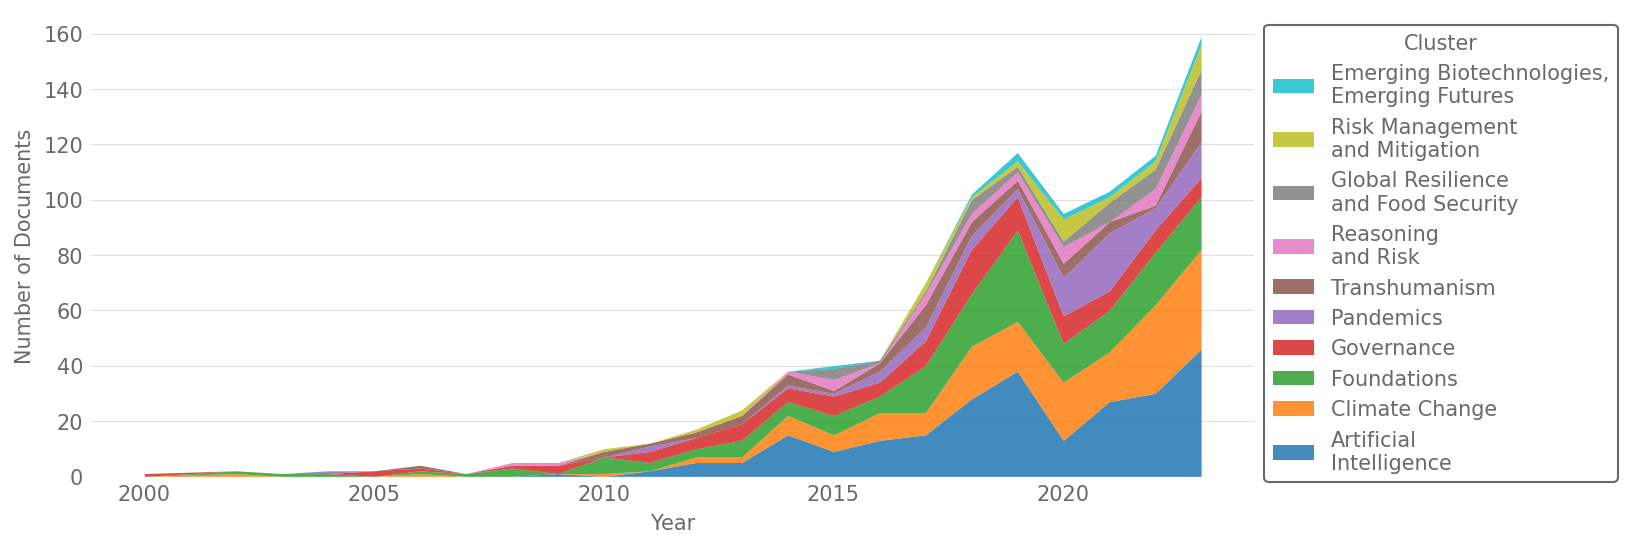

In [8]:
# Plot the area chart
ax = cluster_years.plot(kind="area", colormap="tab10", linewidth=0, alpha = 0.85)

# Get the handles and labels from the current legend
handles, labels = ax.get_legend_handles_labels()

# Reverse the order of both handles and labels
ax.legend(handles[::-1], labels[::-1], title="Cluster", bbox_to_anchor=(1, 1))

# Set y-axis label
plt.ylabel("Number of Documents")

# Remove gridlines from the x-axis
plt.gca().xaxis.grid(False)

fig = plt.gcf()
fig.set_size_inches(10, 4)

# Save 
plt.savefig(f"results{os.sep}figure_3.png", bbox_inches="tight", dpi=300)


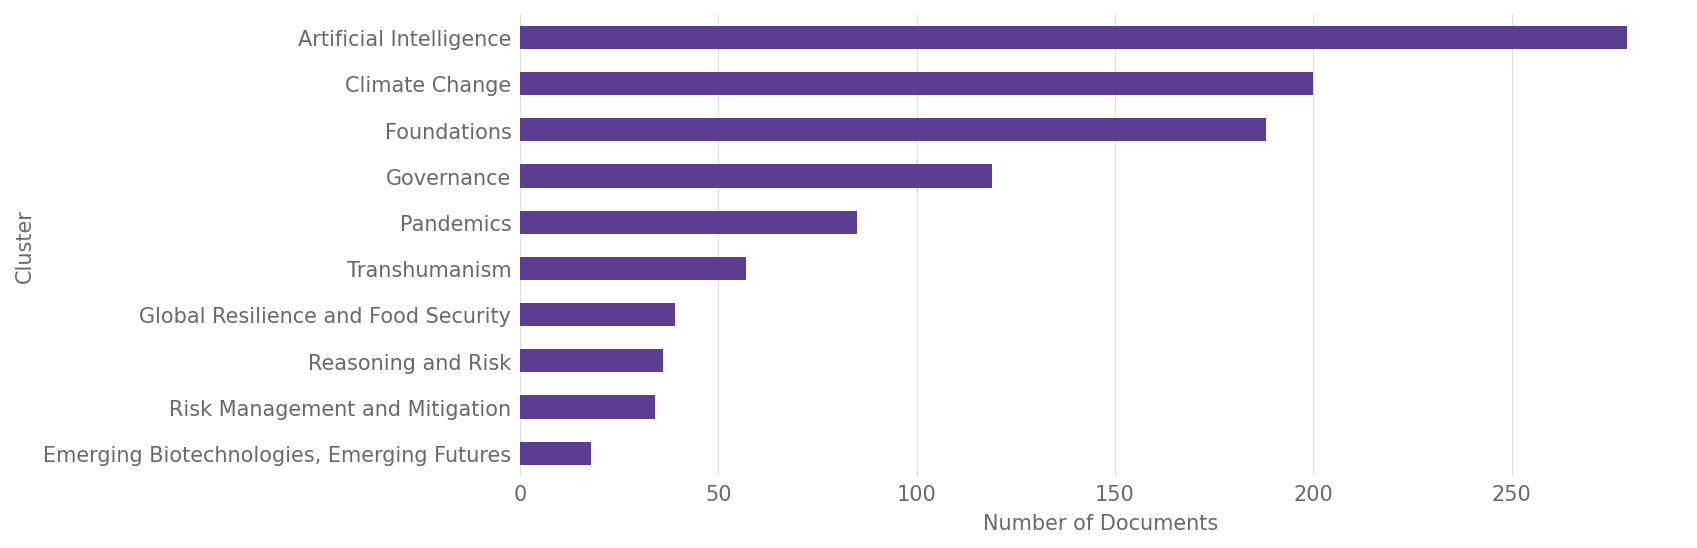

In [9]:
# Create a barplot that shows the number of papers per cluster
cluster_counts = remerged_data["Cluster"].value_counts().sort_values(ascending=True)
cluster_counts.index = cluster_counts.index.map(cluster_names)
cluster_counts.plot(kind="barh", color=main_color)
plt.xlabel("Number of Documents")
plt.ylabel("Cluster")
plt.gca().yaxis.grid(False)

plt.savefig(f"results{os.sep}figure_S1.png", bbox_inches="tight", dpi=300)


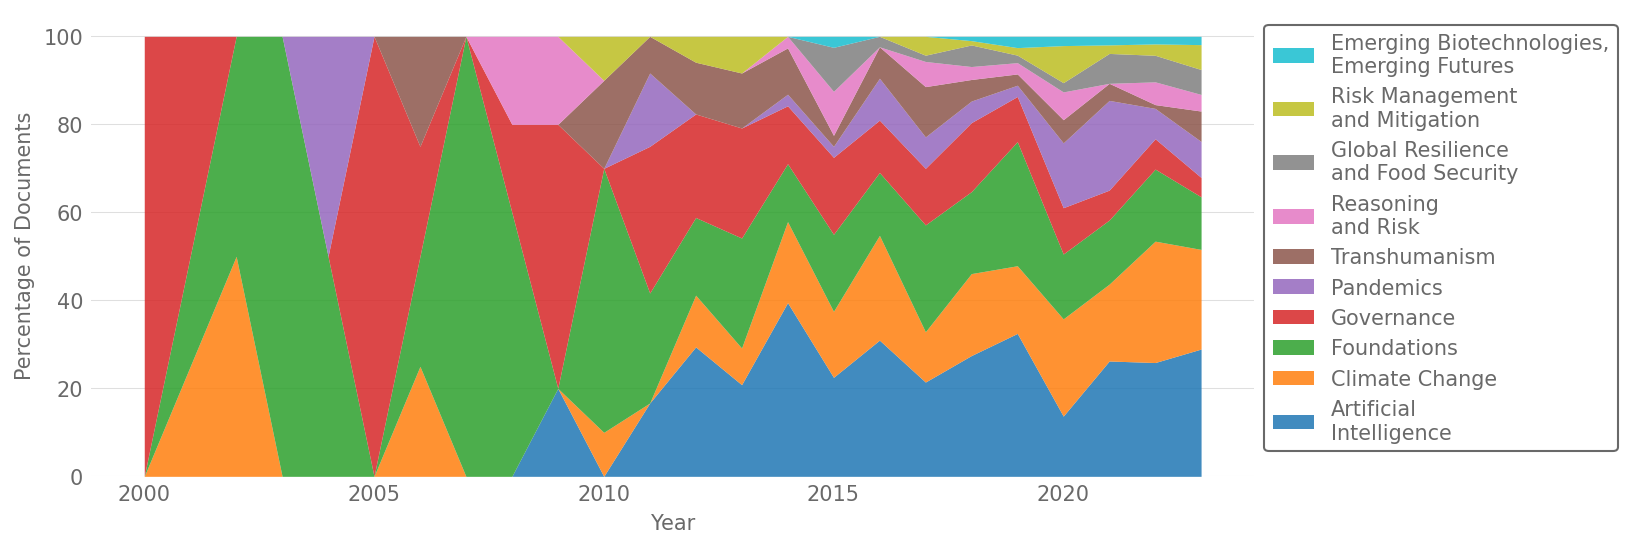

In [10]:
# And now the same plot but with the percentage of papers in each cluster
# Only do this from 2010 onwards
cluster_years_percentage = cluster_years.loc[2000:].div(cluster_years.loc[2000:].sum(axis=1), axis=0) * 100
cluster_years_percentage.plot(kind="area", colormap="tab10", linewidth=0, alpha = 0.85)
plt.gca().legend().set_title("Cluster")
# Reverse the order of both handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::-1], labels[::-1]).set_bbox_to_anchor((1, 1))
plt.ylabel("Percentage of Documents")
plt.gca().xaxis.grid(False)

plt.savefig(f"results{os.sep}figure_S2.png", bbox_inches="tight", dpi=300)

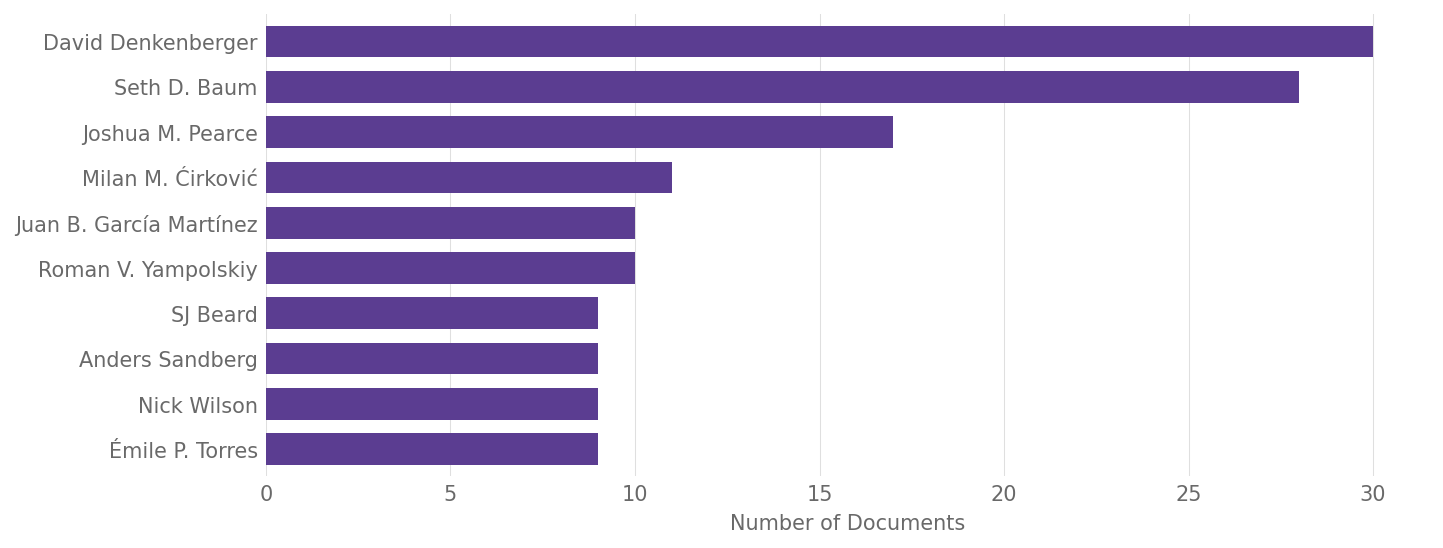

In [11]:
authors = remerged_data["Authors"].apply(ast.literal_eval)
# Create a list of all the authors
all_authors = [author for authors_list in authors for author in authors_list]
# Remove the trailing whitespace from the authors
all_authors = [author.strip() for author in all_authors]
all_authors = [author for author in all_authors if author != ""]
# Count how often each author appears
author_counts = pd.Series(all_authors).value_counts()
# Replace author names from which we know that they want to be called differently
author_counts = author_counts.rename(lambda x: x.replace("Simon Beard", "SJ Beard").replace("Phil Torres", "Émile P. Torres"))
author_counts.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)
# Remove the x-axis grid
plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")
plt.savefig(f"results{os.sep}figure_4.png", bbox_inches="tight", dpi=300)
plt.show()



In [12]:
gender_detector = gg.Detector()
# Go through all the authors and get their gender
gender_counts_all = {"male": 0, "female": 0, "unknown": 0, "mostly_male": 0, "mostly_female": 0, "andy": 0}
for author in set(all_authors):
    # Only use the first name
    first_name = author.split(" ")[0]
    # Get the gender
    gender = gender_detector.get_gender(first_name)
    gender_counts_all[gender] += 1

counter = {"male": 0, "female": 0, "unknown": 0, "mostly_male": 0, "mostly_female": 0, "andy": 0}
gender_counts_cluster = {cluster: counter.copy() for cluster in remerged_data["Cluster"].unique()}
for cluster_name, cluster in remerged_data.groupby("Cluster"):
    num_papers = cluster.shape[0]
    authors = cluster["Authors"].apply(ast.literal_eval)
    # Create a list of all the authors
    all_authors = [author for authors_list in authors for author in authors_list]
    # Remove the trailing whitespace from the authors
    all_authors = [author.strip() for author in all_authors]
    # Go through all the authors and determine their gender
    for author in set(all_authors):
        # Only use the first name
        first_name = author.split(" ")[0]
        # Get the gender
        gender = gender_detector.get_gender(first_name)
        gender_counts_cluster[cluster_name][gender] += 1


In [13]:
gender_df_all = pd.DataFrame(gender_counts_all, index=["All Clusters"])
# Create a DataFrame
gender_df = pd.DataFrame(gender_counts_cluster).transpose()
# combine the two DataFrames
gender_df = pd.concat([gender_df_all, gender_df], axis=0)
# Replace the cluster numbers with their names
gender_df.index = gender_df.index.map(lambda x: cluster_names.get(x, x))
gender_df

,male,female,unknown,mostly_male,mostly_female,andy
All Clusters,1210,489,353,51,42,36
Governance,132,58,30,2,2,2
Artificial Intelligence,319,95,90,11,8,20
Foundations,207,57,39,10,5,1
Pandemics,124,73,49,8,9,4
Climate Change,301,141,93,10,10,8
Transhumanism,43,17,11,2,0,1
Risk Management and Mitigation,49,13,13,2,2,0
"Emerging Biotechnologies, Emerging Futures",36,25,8,3,7,0
Reasoning and Risk,34,16,18,2,1,0


In [14]:
gender_df["total_male"] = gender_df["male"] + gender_df["mostly_male"]
gender_df["total_female"] = gender_df["female"] + gender_df["mostly_female"]
gender_df["total_gender"] = gender_df["total_male"] + gender_df["total_female"]
gender_df["Male"] = gender_df["total_male"] / gender_df["total_gender"] * 100
gender_df["Female"] = gender_df["total_female"] / gender_df["total_gender"] * 100
gender_df

,male,female,unknown,mostly_male,mostly_female,andy,total_male,total_female,total_gender,Male,Female
All Clusters,1210,489,353,51,42,36,1261,531,1792,70.368304,29.631696
Governance,132,58,30,2,2,2,134,60,194,69.072165,30.927835
Artificial Intelligence,319,95,90,11,8,20,330,103,433,76.212471,23.787529
Foundations,207,57,39,10,5,1,217,62,279,77.777778,22.222222
Pandemics,124,73,49,8,9,4,132,82,214,61.682243,38.317757
Climate Change,301,141,93,10,10,8,311,151,462,67.316017,32.683983
Transhumanism,43,17,11,2,0,1,45,17,62,72.580645,27.419355
Risk Management and Mitigation,49,13,13,2,2,0,51,15,66,77.272727,22.727273
"Emerging Biotechnologies, Emerging Futures",36,25,8,3,7,0,39,32,71,54.929577,45.070423
Reasoning and Risk,34,16,18,2,1,0,36,17,53,67.924528,32.075472


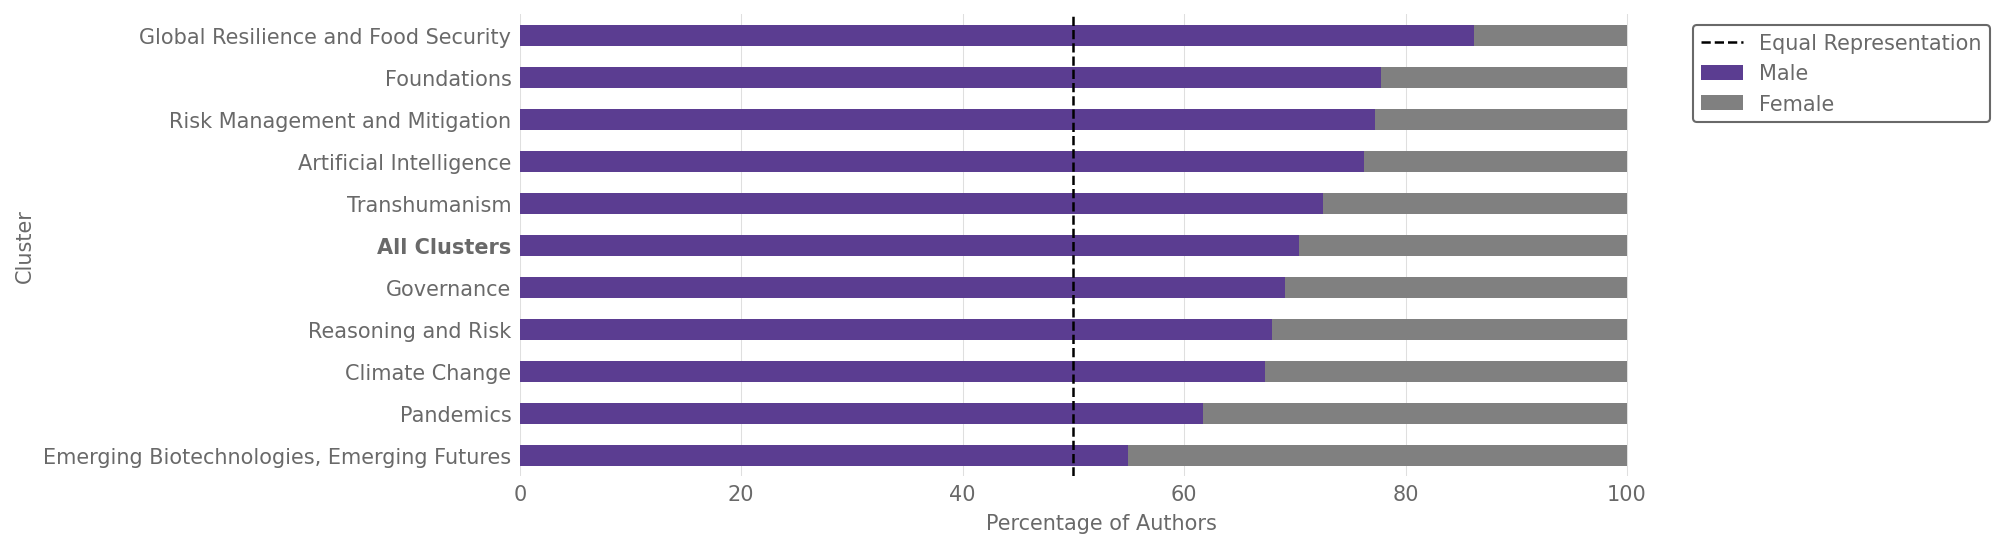

In [15]:
# Create a stacked barplot that shows the percentage of male and femlae authors per cluster
gender_df[["Male", "Female"]].sort_values(by="Male").plot(kind="barh", stacked=True, color=["#5b3d91", "gray"])
# add a vertical line at 50% labeled "Equal Representation"
plt.axvline(x=50, color="black", linestyle="--", label="Equal Representation", linewidth=1.2)
plt.xlabel("Percentage of Authors")
plt.ylabel("Cluster")
plt.gca().yaxis.grid(False)
# Move legend to the right of the plot
plt.legend().set_bbox_to_anchor((1, 1))
# Make the label "All Clusters" bold
plt.gca().get_yticklabels()[5].set_weight("bold")

plt.savefig(f"results{os.sep}figure_5.png", bbox_inches="tight", dpi=300)

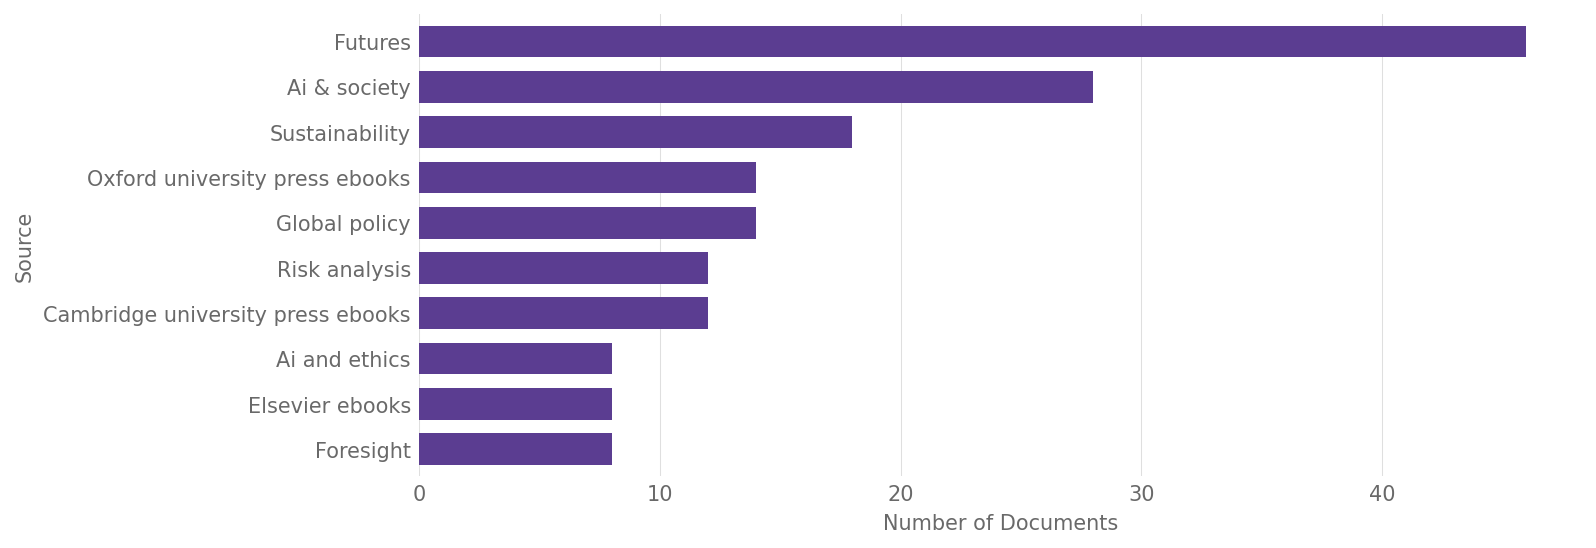

In [16]:
# Detect the main journals for the whole dataset
journals = remerged_data["Source"].value_counts()
# Remove "[no source]" from the journals
journals = journals.drop("[no source]")
journals.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)

plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")

plt.savefig(f"results{os.sep}figure_6.png", bbox_inches="tight", dpi=300)

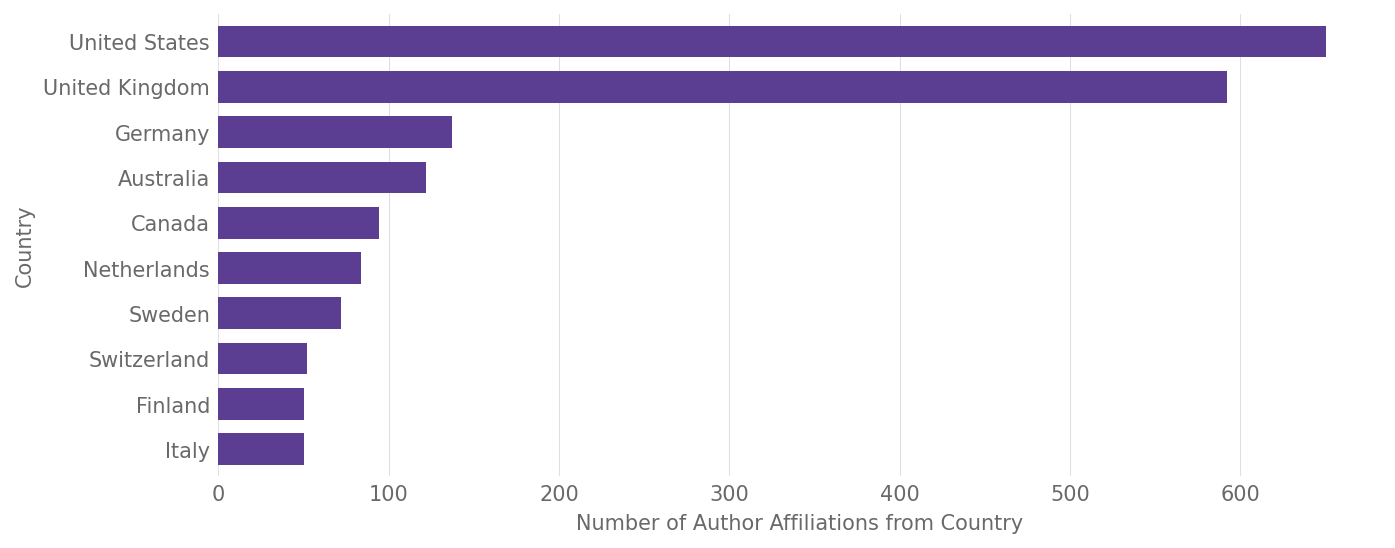

In [17]:
# Look at the main countries for the whole dataset
countries = remerged_data["authorships.countries"].str.split("|").explode().value_counts()
# Remove the empty countries
countries = countries.drop("")
# Convert the country codes to names
country_codes = countries.index
countries.index = coco.convert(names=country_codes, to="name_short")

countries.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)
plt.gca().yaxis.grid(False)
plt.xlabel("Number of Author Affiliations from Country")
plt.ylabel("Country")

plt.savefig(f"results{os.sep}figure_S7.png", bbox_inches="tight", dpi=300)


In [18]:
countries

United States          650
United Kingdom         592
Germany                137
Australia              122
Canada                  94
                      ... 
Zambia                   1
Costa Rica               1
Trinidad and Tobago      1
Macau                    1
Lebanon                  1
Name: count, Length: 82, dtype: int64

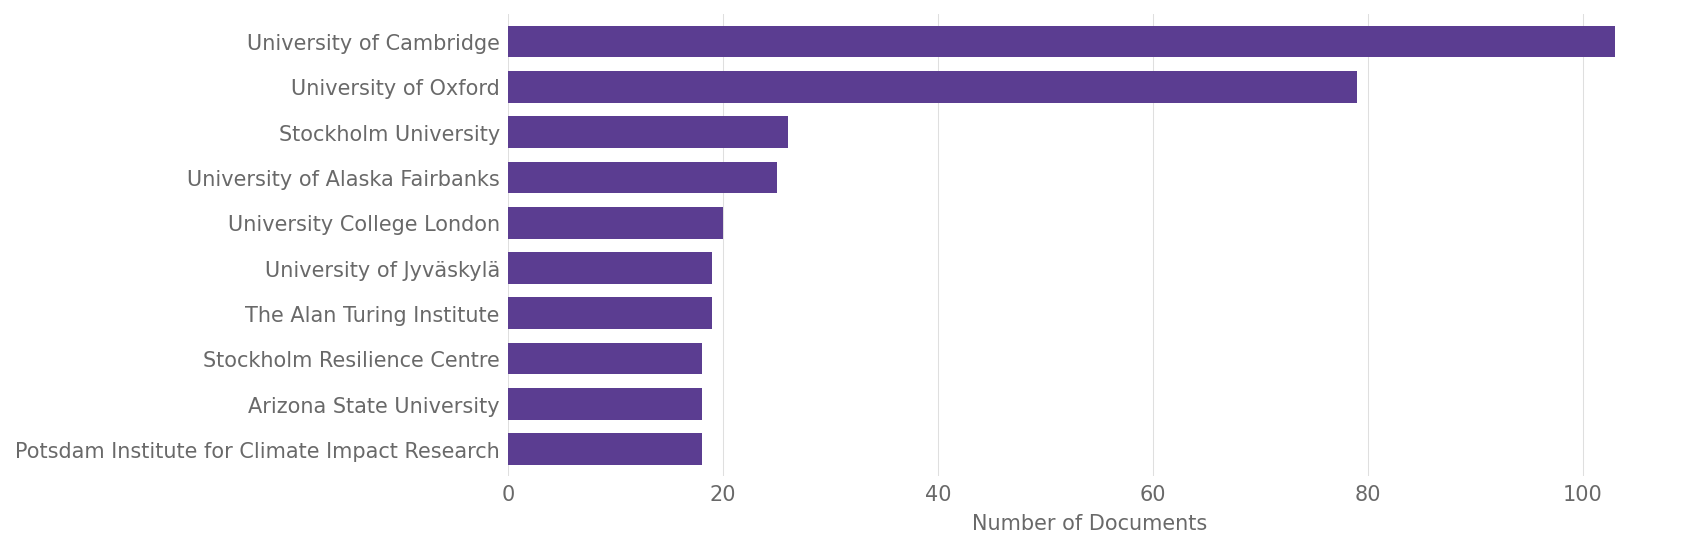

In [19]:
# Create a plot of all the organizations
# make a copy of the data
remerged_data_for_orgs = remerged_data.copy()
# Remove the rows with no organizations
remerged_data_for_orgs = remerged_data_for_orgs[remerged_data_for_orgs["authorships.institutions"].notnull()]

def extract_display_names(df, column_name):
    def parse_and_extract(dict_string):
        try:
            # Use ast.literal_eval to safely evaluate the dictionary string
            dict_obj = ast.literal_eval(dict_string)
            return dict_obj['display_name']
        except:
            return None

    # Split the column by '|' and apply the parsing function
    df['display_names'] = df[column_name].str.split('|').apply(
        lambda x: [parse_and_extract(d) for d in x if d]
    )

    return df


remerged_data_for_orgs = extract_display_names(remerged_data_for_orgs, 'authorships.institutions')

# Create a list of all the organizations
all_orgs = [org for org_list in remerged_data_for_orgs['display_names'] for org in org_list]
# Remove the empty organizations
all_orgs = [org for org in all_orgs if org != ""]
# Remove "Open Targets", "Deutsche Gesellschaft für Internationale Zusammenarbeit", "Global Environment Facility" and "Action Network"
# as they are all false positives from the same entry
all_orgs = [org for org in all_orgs if org != "Open Targets"]
all_orgs = [org for org in all_orgs if org != "Deutsche Gesellschaft für Internationale Zusammenarbeit"]
all_orgs = [org for org in all_orgs if org != "Action Network"]
all_orgs = [org for org in all_orgs if org != "Global Environment Facility"]

# Count how often each organization appears
org_counts = pd.Series(all_orgs).value_counts()
org_counts.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)
plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")

plt.savefig(f"results{os.sep}figure_S5.png", bbox_inches="tight", dpi=300)

Text(0, 0.5, 'Topic')

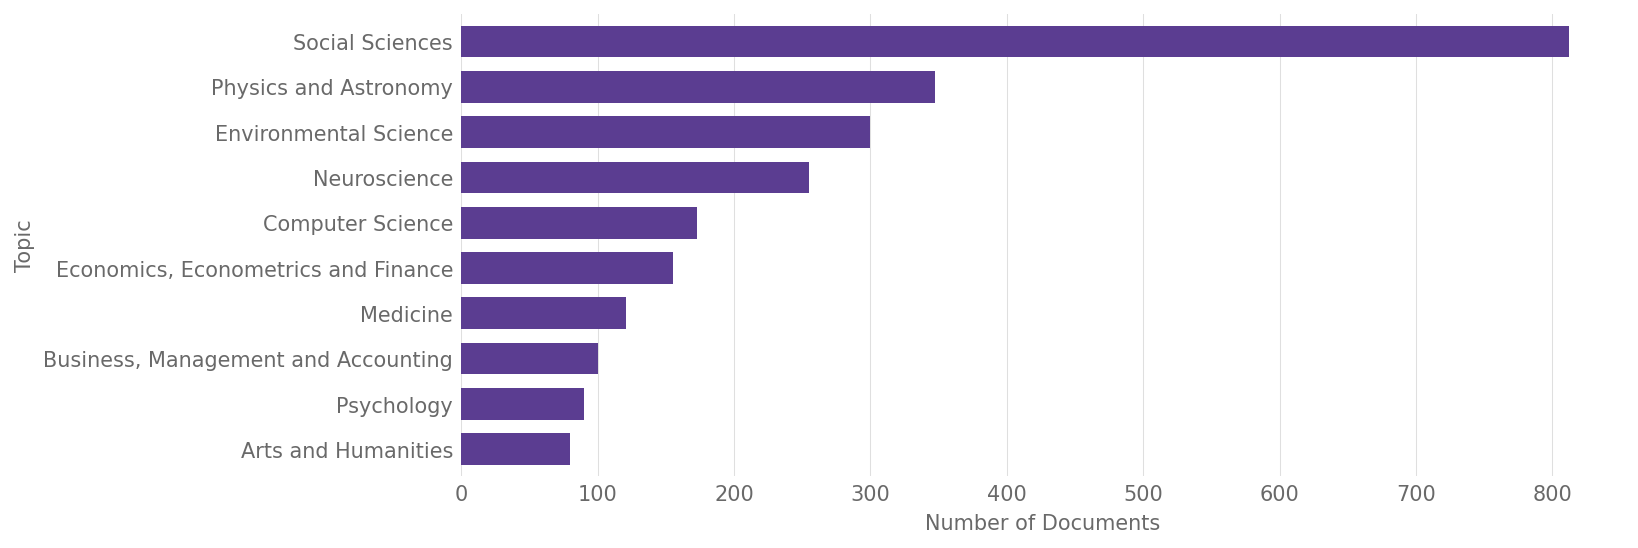

In [20]:
# Detect the main topics for the whole dataset
topics = remerged_data["topics.field.display_name"].str.split("|").explode().value_counts()

topics.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)

plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")
plt.ylabel("Topic")

Text(0, 0.5, 'Keyword')

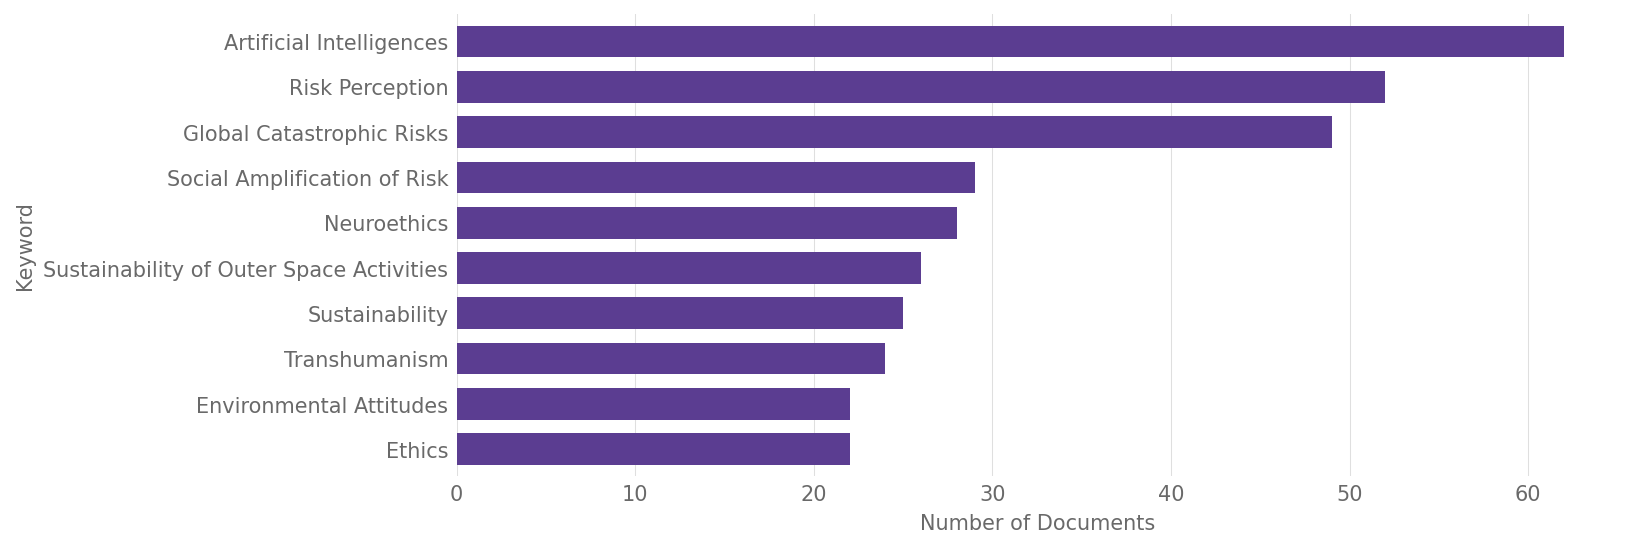

In [21]:
# Detect the main topics for the whole dataset
topics = remerged_data["keywords.display_name"].str.split("|").explode().value_counts()

topics.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)

plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")
plt.ylabel("Keyword")

Text(0, 0.5, 'Concept')

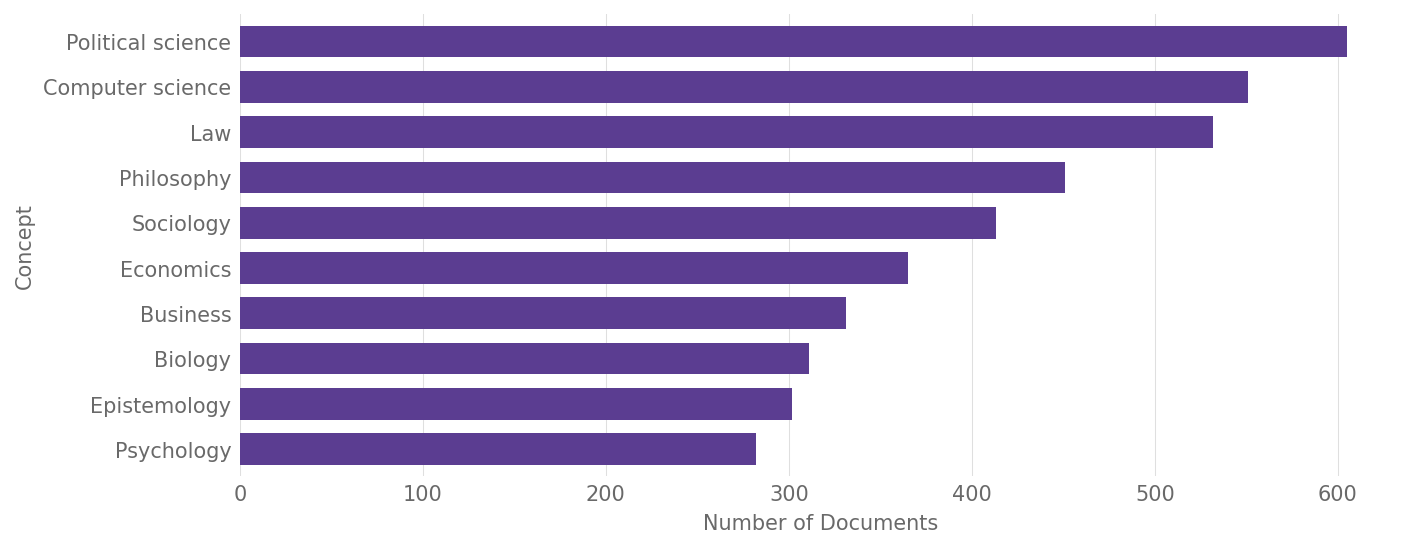

In [22]:
# Detect the main topics for the whole dataset
topics = remerged_data["concepts.display_name"].str.split("|").explode().value_counts()

topics.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)

plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")
plt.ylabel("Concept")